In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

In [2]:
df= pd.read_csv('course_lead_scoring2.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


#### Data preparation

In [5]:
categorical= ['lead_source','industry','employment_status', 'location']
numerical= ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [6]:
df[categorical]=df[categorical].fillna('NA')
df[numerical]=df[numerical].fillna(0.0)

In [7]:
df_full_train, df_test= train_test_split(df, test_size= 0.2, random_state=1)
len(df_full_train), len(df_test)

(1169, 293)

In [8]:
df_train, df_val= train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val)

(876, 293)

In [9]:
df_train= df_train.reset_index(drop=True)
df_test= df_test.reset_index(drop=True)
df_val= df_val.reset_index(drop=True)

In [10]:
y_train= df_train.converted.values
y_test= df_test.converted.values
y_val= df_val.converted.values

In [11]:
del df_train['converted']
del df_test['converted']
del df_val['converted']

#### Question 1: ROC AUC feature importance

In [13]:
cols= ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

In [14]:
feature_auc_scores = {}

# Calculate ROC AUC for each individual feature
for col in cols:
    # Use a simple classifier (e.g., Logistic Regression)
    model = LogisticRegression()
    model.fit(df_train[[col]], y_train)
    y_pred_proba = model.predict_proba(df_train[[col]])[:, 1]
    auc = roc_auc_score(y_train, y_pred_proba)
    feature_auc_scores[col] = auc
for feature, auc in feature_auc_scores.items():
        print(f"Feature: {feature}, AUC: {auc:.4f}")

Feature: lead_score, AUC: 0.6145
Feature: number_of_courses_viewed, AUC: 0.7636
Feature: interaction_count, AUC: 0.7383
Feature: annual_income, AUC: 0.5520


Which numerical variable (among the following 4) has the highest AUC?

In [16]:
#Feature: number_of_courses_viewed, AUC: 0.7636

In [49]:
dicts= df_train[categorical + numerical].to_dict(orient='records')
dicts_val= df_val[categorical + numerical].to_dict(orient='records')
dv= DictVectorizer(sparse= False)
X_train= dv.fit_transform(dicts)
model1= LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model1.fit(X_train, y_train)
X_val= dv.fit_transform(dicts_val)
y_pred= model1.predict_proba(X_val)[:,1]
round(accuracy_score(y_val, y_pred >= 0.5),2)

0.7

#### Question 3: Precision and Recall

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


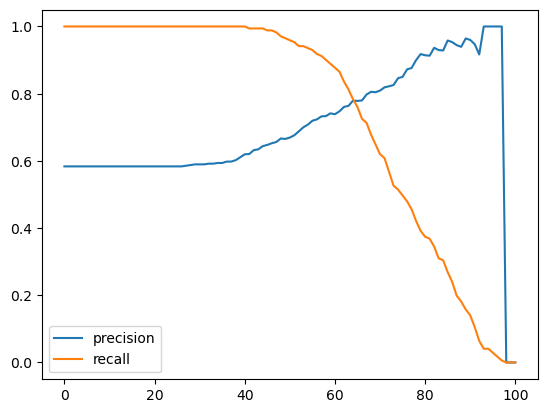

In [111]:
p=[]
r=[]
for t in np.arange(0.0, 1.01, 0.01):
    precision= precision_score(y_val,y_pred >= t)
    p.append(precision)
    recall= recall_score(y_val,y_pred >= t)
    r.append(recall)
plt.plot(p,label='precision' )
plt.plot(r,label='recall' )
plt.legend()
plt.show()

In [113]:
#0.745

#### Question 4: F1 score

In [77]:
for t in np.arange(0.0, 1.01, 0.01):
    score= f1_score(y_val,y_pred >= t)
    if t in [0.14, 0.34, 0.54, 0.74]:
        print(t, score)
    

0.14 0.7370689655172413
0.34 0.7450980392156863
0.54 0.8060453400503779
0.74 0.64


In [79]:
#0.54 has maximum f1-score

#### Question 5: 5-Fold CV

In [123]:
def train(df,y):
    dicts= df[categorical + numerical].to_dict(orient= 'records')
    dv= DictVectorizer(sparse= False)
    X_train= dv.fit_transform(dicts)
    model= LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [131]:
def predict(df, dv, model):
    dicts= df[categorical + numerical].to_dict(orient= 'records')
    X= dv.transform(dicts)
    y_pred= model.predict_proba(X)[:,1]
    return y_pred

In [83]:
kfold= KFold(n_splits=5, shuffle=True, random_state=1)

In [135]:
scores=[]
for train_idx, val_idx in kfold.split(df_full_train):
    df_train= df_full_train.iloc[train_idx]
    df_val= df_full_train.iloc[val_idx]
    y_train= df_train.converted.values
    y_val= df_val.converted.values
    dv,model= train(df_train, y_train)
    y_pred= predict(df_val,dv, model)
    auc= roc_auc_score(y_val,y_pred)
    scores.append(auc)
    


In [145]:
np.std(scores)

0.03580711942905165

#### Question 6: Hyperparameter Tuning

In [148]:
def train(df,y, C=1.0):
    dicts= df[categorical + numerical].to_dict(orient= 'records')
    dv= DictVectorizer(sparse= False)
    X_train= dv.fit_transform(dicts)
    model= LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [160]:
c= [0.000001, 0.001, 1]
for v in c:
    scores=[]
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train= df_full_train.iloc[train_idx]
        df_val= df_full_train.iloc[val_idx]
        y_train= df_train.converted.values
        y_val= df_val.converted.values
        dv,model= train(df_train, y_train, C=v)
        y_pred= predict(df_val,dv, model)
        auc= roc_auc_score(y_val,y_pred)
        scores.append(auc)
    print(v, round(np.mean(scores),3))


1e-06 0.56
0.001 0.867
1 0.822


In [158]:
#C= 0.001